## Python DAME-FLAME package used to analyze STAR Dataset

Here we demonstrate an experimental use-case for the DAME algorithm on the Tennessee’s
Student Teachers Achievement Ratio (STAR) Dataset. This dataset originates from an experiment
beginning in 1985, in which elementary school students and their teachers across 79
schools in Tennessee were randomly assigned to classes of small or regular sizes from Kindergarten
through 3rd grade (Achilles, Bain, Bellott, Boyd-Zaharias, Finn, Folger, Johnston,
and Word 2008). Although data is available for students not participating in the experiment,
we limit to the experimental dataset in which treatment was random. The results showed
that a small class size attendance leads to higher standardized test performance, and long
term benefits in increased college entrance exam taking, especially among minority students
(Krueger and Whitmore 2001).

### 1. Clean Dataset
Our cleaned dataset has around 5000 students with reading scores ranging from 315 to 627.
Our covariates include children’s characteristics, teacher’s characteristics and school characteristics.
The children’s characteristics are gender, race (binary, with White and Asian in one
group, and all other races in the other group), free lunch status, and age in months (binned
into deciles). The teacher characteristics include race, gender, and having a higher degree
than bachelors. The school characteristics are urbanicity (rural, urban, suburban, and inner
city) and a school identification number, with one for each of the 79 schools.

Please download the data here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/10766

In [1]:
import dame_flame
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import heapq
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelBinarizer
from statsmodels.distributions.empirical_distribution import ECDF

C:\Users\Neha\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
STAR_Students = pd.read_spss('STAR_Students.sav')

In [3]:
df_trunc = STAR_Students.loc[:, STAR_Students.columns.intersection(
    ['gkclasstype', 'gender', 'race', 'gkfreelunch', 'gkschid', 'gktmathss', 'gktreadss', 'g1freelunch', 'g2freelunch', 'g3freelunch',
    'gktgen', 'gktrace', 'gkthighdegree', 'birthmonth', 'birthyear', 'gksurban'])]


d = {"WHITE": 1, "BLACK": 0, "ASIAN": 1, "HISPANIC": 0, "OTHER": 0, 
     "NATIVE AMERICAN": 0}
df_trunc['race'] = df_trunc['race'].map(d)

d = {"NON-FREE LUNCH": 0, "FREE LUNCH": 1}
df_trunc['gkfreelunch'] = df_trunc['gkfreelunch'].map(d)
df_trunc['g1freelunch'] = df_trunc['g1freelunch'].map(d)
df_trunc['g2freelunch'] = df_trunc['g2freelunch'].map(d)
df_trunc['g3freelunch'] = df_trunc['g3freelunch'].map(d)

d = {"BACHELORS": 0, "MASTERS": 1, "MASTERS + ": 1, "SPECIALIST": 1}
df_trunc['gkthighdegree'] = df_trunc['gkthighdegree'].map(d)

d = {"MALE": 1, "FEMALE": 0}
df_trunc['gender'] = df_trunc['gender'].map(d)
df_trunc['gktgen'] = df_trunc['gktgen'].map(d)

d = {"WHITE": 1, "BLACK": 0}
df_trunc['gktrace'] = df_trunc['gktrace'].map(d)

d = {"JANUARY": 0, "FEBRUARY": 1, "MARCH": 2, "APRIL": 3, "MAY": 4, 
     "JUNE": 5, "JULY": 6, "AUGUST": 7, "SEPTEMBER": 8, "OCTOBER": 9, 
     "NOVEMBER": 10, "DECEMBER": 11}
df_trunc['birthmonth'] = df_trunc['birthmonth'].map(d)

d = {1977: 0, 1978: 1, 1979: 2, 1980:3, 1981:4}
df_trunc['birthyear'] = df_trunc['birthyear'].map(d)

d = {"RURAL": 0, "URBAN":1, "SUBURBAN": 2, "INNER CITY": 3}
df_trunc['gksurban'] = df_trunc['gksurban'].map(d)

d = {"SMALL CLASS": int(1), "REGULAR CLASS": int(0), 
     "REGULAR + AIDE CLASS": int(0)}
df_trunc['ksmall'] = df_trunc['gkclasstype'].map(d)

# Create age variable counting months
df_trunc['age'] = df_trunc['birthyear']*12 + df_trunc['birthmonth']
# Bin age into deciles
df_trunc['age'] = pd.qcut(df_trunc['age'], q=10, labels=False)
df_trunc = df_trunc.drop(columns=['gkclasstype', 'birthmonth', 'birthyear'])
df_trunc = df_trunc.rename(columns={"ksmall": "treated"}) ## NOTE TO SELF -- COME BACK TO WE SHOULDNT HAVE TO DO THIS

### 2. Replicate Results of Other Papers
Notably, the works of Krueger AB, Whitmore DM (2001) and Krueger (1999) estimates a linear regression of small class sizes with other covariates on an outcome of percentile test scores and finds a 5-6 percentile difference. In Figure 1, the leftmost square-shaped bullet point is being replicated here.

In [4]:
for i in df_trunc.index:
    if df_trunc.loc[i, 'g1freelunch'] == 1 or df_trunc.loc[i, 'g2freelunch'] == 1 or df_trunc.loc[i, 'g3freelunch'] == 1 or df_trunc.loc[i, 'gkfreelunch'] == 1:
        df_trunc.loc[i, 'gkfreelunch'] = 1
    else:
        df_trunc.loc[i, 'gkfreelunch'] = 0
df_trunc = df_trunc.drop(columns=['g1freelunch', 'g2freelunch', 'g3freelunch'])

df_trunc = df_trunc.dropna()

In [5]:
ecdf_reading = ECDF(df_trunc[df_trunc['treated'] == 0]['gktreadss'])
ecdf_math = ECDF(df_trunc[df_trunc['treated'] == 0]['gktmathss'])
df_trunc['read_outcome'] = ecdf_reading(df_trunc['gktreadss'])*100
df_trunc['math_outcome'] = ecdf_math(df_trunc['gktmathss'])*100
df_trunc['outcome'] = (df_trunc['read_outcome'] + df_trunc['math_outcome'])/2

We run the fixed effects regression using (1) fixed effects regression package with just the school fixed effects and the treatment variable, (2) the fixed effects regression package with the treatment other variables and with school fixed effects, and (3) OLS with school variables, other variables, and the treated. Each time, we see approximately the same coefficients for the treated variable.

In [6]:
md = smf.mixedlm(formula="outcome ~ treated", data=df_trunc , groups=df_trunc['gkschid'])
md.fit().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: outcome    
No. Observations: 5120    Method:             REML       
No. Groups:       79      Scale:              558.7809   
Min. group size:  30      Likelihood:         -23574.6243
Max. group size:  123     Converged:          Yes        
Mean group size:  64.8                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      51.109    1.536 33.284 0.000 48.099 54.119
treated         5.572    0.736  7.572 0.000  4.130  7.014
Group Var     173.039    1.245                           
=========================================================

"""

In [7]:
md = smf.mixedlm(formula="outcome ~ gender+race+gkfreelunch+treated", data=df_trunc, groups=df_trunc['gkschid'])
md.fit().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
============================================================
Model:             MixedLM  Dependent Variable:  outcome    
No. Observations:  5120     Method:              REML       
No. Groups:        79       Scale:               517.1212   
Min. group size:   30       Likelihood:          -23369.5767
Max. group size:   123      Converged:           Yes        
Mean group size:   64.8                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         41.559    1.708 24.335 0.000 38.212 44.906
gender[T.1]       -4.763    0.640 -7.440 0.000 -6.018 -3.508
gkfreelunch[T.0]  12.274    0.771 15.928 0.000 10.764 13.785
race               9.296    1.277  7.278 0.000  6.793 11.800
treated            5.579    0.708  7.881 0.000  4.191  6.966
Group Var        147.623    1.111                           
============================================================

"""

In [8]:
fes = pd.get_dummies(df_trunc['gkschid'])
fes = fes.drop(columns=[161183.0]) # have to drop one before running a fixed effects regression
y = df_trunc.loc[:,['outcome']]
x = df_trunc.loc[:, ['gender', 'race', 'gkfreelunch', 'treated']]
x = pd.concat([fes,x],axis=1)
x = sm.add_constant(x)
model = sm.OLS(y,x)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     27.30
Date:                Sun, 19 Feb 2023   Prob (F-statistic):               0.00
Time:                        20:20:32   Log-Likelihood:                -23219.
No. Observations:                5120   AIC:                         4.660e+04
Df Residuals:                    5037   BIC:                         4.715e+04
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          60.7510      2.771     21.927      0.000      55.319      66.183
112038.0      -30.2353      4.043     -7.478      0.000     -38.162     -22.308
123056.0      -17.4150      4.103     -4.244      0.000     -25.459      -9.371
128068.0      -18.5177      3.934     -4.707      0.000     -26.231     -10.805
128076.0      -24.7735      3.875     -6.393      0.000     -32.370     -17.177
128079.0      -26.3821      3.865     -6.825      0.000     -33.960     -18.804
130085.0      -18.0859      3.666     -4.933      0.000     -25.274     -10.898
159171.0        9.8644      3.326      2.966      0.003       3.343      16.385
161176.0      -16.6120      3.531     -4.704      0.000     -23.535      -9.689
162184.0      -13.7527      3.888     -3.537      0.000     -21.375      -6.130
164198.0      -10.1512      4.018     -2.526      0.012     -18.028      -2.274
165199.0        2.6009      4.407      0.590      0.555      -6.039      11.241
166203.0      -18.5101      4.285     -4.320      0.000     -26.911     -10.109
168211.0      -10.0551      3.390     -2.966      0.003     -16.701      -3.409
168214.0        2.5600      3.969      0.645      0.519      -5.220      10.340
169219.0        2.9215      4.157      0.703      0.482      -5.227      11.070
169229.0       -2.6218      3.420     -0.767      0.443      -9.327       4.083
169231.0      -27.8323      3.994     -6.969      0.000     -35.662     -20.003
169280.0       -3.5777      4.059     -0.882      0.378     -11.534       4.379
170295.0       -3.0820      3.719     -0.829      0.407     -10.372       4.208
173312.0       13.3713      3.893      3.435      0.001       5.740      21.003
176329.0        5.5987      3.739      1.497      0.134      -1.731      12.929
180344.0       -6.5009      3.426     -1.897      0.058     -13.218       0.216
189378.0      -22.4983      3.657     -6.153      0.000     -29.667     -15.330
189382.0      -11.2480      3.838     -2.931      0.003     -18.772      -3.724
189396.0      -21.6991      3.839     -5.652      0.000     -29.225     -14.173
191411.0       -2.9399      4.489     -0.655      0.513     -11.740       5.860
193422.0        2.0550      3.800      0.541      0.589      -5.395       9.504
193423.0       -4.1142      3.584     -1.148      0.251     -11.140       2.912
201449.0        4.5665      3.465      1.318      0.188      -2.226      11.359
203452.0      -13.7293      3.450     -3.980      0.000     -20.493      -6.966
203457.0        5.4469      4.314      1.263      0.207      -3.010      13.903
205488.0      -12.6341      4.053     -3.117      0.002     -20.581      -4.688
205489.0      -10.6671      4.039     -2.641      0.008     -18.585      -2.749
205490.0      -29.0381      4.010     -7.241      0.000     -36.899     -21.177
205491.0      -15.6385      3.699     -4.22

Successful replication of these results builds confidence in proper data cleaning methodology so we proceed to explore inference on this dataset with the dame-flame package.
## 3. dame-flame on this dataset -- using the percentile outcome variable

In [9]:
df_pre_drop = df_trunc
df_trunc.head()

,gender,race,gkschid,gksurban,gktgen,gktrace,gkthighdegree,gkfreelunch,gktreadss,gktmathss,treated,age,read_outcome,math_outcome,outcome
133,1,0.0,169280.0,2,0,1,0.0,0,427.0,478.0,0.0,5.0,45.086544,51.814629,48.450586
246,0,1.0,218562.0,1,0,1,1.0,1,450.0,494.0,0.0,9.0,74.902289,65.522055,70.212172
263,0,0.0,205492.0,2,0,1,0.0,1,483.0,513.0,1.0,2.0,93.467337,77.610274,85.538805
266,1,1.0,257899.0,0,0,1,1.0,0,456.0,513.0,0.0,2.0,80.988275,77.610274,79.299274
275,1,1.0,161176.0,0,0,1,0.0,1,411.0,468.0,0.0,2.0,22.389726,42.406477,32.398102


In [10]:
df_trunc = df_trunc.drop(columns=['gktreadss', 'gktmathss', 'read_outcome', 'math_outcome'])

In [11]:
# Do the matching

models = []
random_seeds = [1111, 2222, 3333, 4444]
for i in range(4):
    matching_df, holdout_df = train_test_split(df_trunc, test_size=0.2, random_state=random_seeds[i])
    model_dame = dame_flame.matching.DAME(
        repeats=False, verbose=0, adaptive_weights='decisiontree')
    model_dame.fit(holdout_data=holdout_df)
    model_dame.predict(matching_df)
    models.append(model_dame)

2975 units matched. We finished with no more treated units to match
3007 units matched. We finished with no more treated units to match
2943 units matched. We finished with no more treated units to match
2999 units matched. We finished with no more treated units to match


In [12]:
for i in range(len(models)):
    var, ate = dame_flame.utils.post_processing.var_ATE(matching_object=models[i])
    print("ATE of trial", i, ":", ate,". Variance: ", var)


ATE of trial 0 : 5.107351792382683 . Variance:  0.8991877492386828
ATE of trial 1 : 4.889610017616739 . Variance:  0.9123505507663184
ATE of trial 2 : 5.057902885406865 . Variance:  0.8806818133158268
ATE of trial 3 : 5.435432162854705 . Variance:  0.8998682484477298


## 4. Same analysis on dame-flame, except using the kindergarten reading scores outcome

In [13]:
df_trunc = df_pre_drop.drop(columns=['outcome', 'gktmathss', 'read_outcome', 'math_outcome'])

In [14]:
# Do the matching

models = []
random_seeds = [1111, 2222, 3333, 4444]
for i in range(4):
    matching_df, holdout_df = train_test_split(df_trunc, test_size=0.2, random_state=random_seeds[i])
    model_dame = dame_flame.matching.DAME(
        repeats=False, verbose=0, adaptive_weights='decisiontree')
    model_dame.fit(holdout_data=holdout_df, outcome_column_name='gktreadss')
    model_dame.predict(matching_df)
    models.append(model_dame)

2989 units matched. We finished with no more treated units to match
2983 units matched. We finished with no more treated units to match
2945 units matched. We finished with no more treated units to match
2991 units matched. We finished with no more treated units to match


In [15]:
ates = []
for i in range(len(models)):
    var, ate = dame_flame.utils.post_processing.var_ATE(matching_object=models[i])
    print("ATE of trial", i, ":", ate,". Variance: ", var)
    ates.append(ate)

ATE of trial 0 : 5.173624055398901 . Variance:  1.422310938161257
ATE of trial 1 : 5.780208482990914 . Variance:  1.3736679478829965
ATE of trial 2 : 5.932743221690592 . Variance:  1.3477288982910676
ATE of trial 3 : 5.750402040472252 . Variance:  1.3864610041025858


In [16]:
# compute stuff for plot
match_dfs = []
for i in models:
    match_dfs.append(i.input_data)

for i in range(4):
    colname = 'cates'
    match_dfs[i][colname] = dame_flame.utils.post_processing.CATE(
        models[i], match_dfs[i].index)

dame_len_groups = []
dame_cate_of_groups = []

for i in range(4):

    model_dame = models[i]
    groups = list(range(len(model_dame.units_per_group)))

    dame_cate_of_group = []
    dame_len_group = []
    dame_len_treated = []
    maxcate = 0.0
    maxgroupnum = 0
    index = 0

    flame_cate_of_group = []
    flame_len_group = []
    large_groups = []
    for group in model_dame.units_per_group:
        dame_cate_of_group.append(dame_flame.utils.post_processing.CATE(
            model_dame, group[0]))
        dame_len_group.append(len(group))

        # find len of just treated units
        df_mmg = df_trunc.loc[group]
        treated = df_mmg.loc[df_mmg["treated"] == 1]

    dame_len_groups.append(dame_len_group)
    dame_cate_of_groups.append(dame_cate_of_group)

C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Neha\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

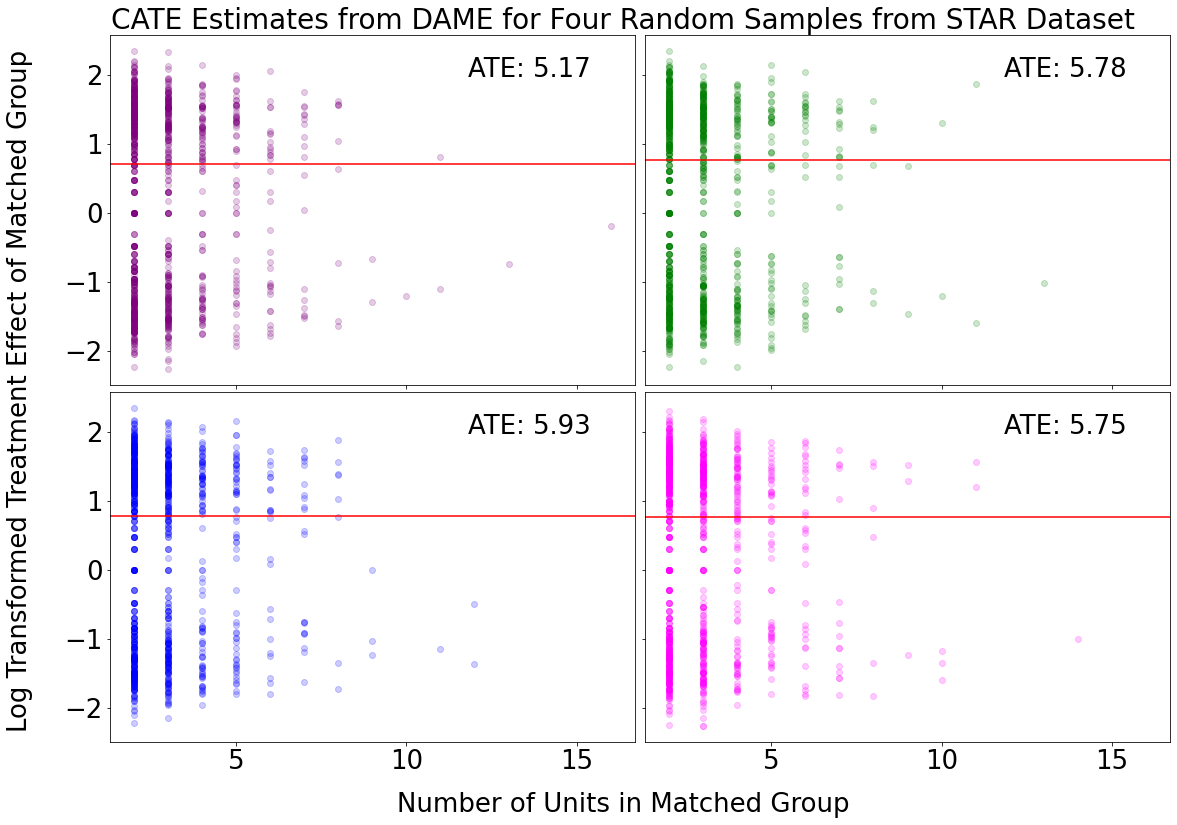

In [17]:
# Create the plot, Figure 2 in the paper

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (19,13), 
                                             sharex=True, sharey=True)
fig.text(0.5, 0.05, 'Number of Units in Matched Group', ha='center', 
         fontsize=26)
fig.text(0.05, 0.5, 'Log Transformed Treatment Effect of Matched Group', 
         va='center', rotation='vertical', fontsize=26)
fig.suptitle("CATE Estimates from DAME for Four Random Samples from STAR Dataset", fontsize=28, y=0.91)
ax1.axhline(y=np.log10(ates[0]), color='r', linestyle='-')
ax2.axhline(y=np.log10(ates[1]), color='r', linestyle='-')
ax3.axhline(y=np.log10(ates[2]), color='r', linestyle='-')
ax4.axhline(y=np.log10(ates[3]), color='r', linestyle='-')

ax1.tick_params(labelsize=26)
ax2.tick_params(labelsize=26)
ax3.tick_params(labelsize=26)
ax4.tick_params(labelsize=26)

al=0.2

temp = np.array(dame_cate_of_groups[0])
result = np.log10(temp, where=temp>0, out=temp)
result = -1*np.log10(result*-1, where=result<0,out=result*-1)
ax1.scatter(dame_len_groups[0], result, color="purple", 
            alpha = al)
ax1.text(0.8, 0.9,'ATE: '+str(round(ates[0],2)), ha='center', va='center',
         transform=ax1.transAxes, fontsize=26)

temp = np.array(dame_cate_of_groups[1])
result = np.log10(temp, where=temp>0, out=temp)
result = -1*np.log10(result*-1, where=result<0,out=result*-1)
ax2.scatter(dame_len_groups[1], result, color="green", 
            alpha = al)
ax2.text(0.8, 0.9,'ATE: '+str(round(ates[1],2)), ha='center', va='center',
         transform=ax2.transAxes, fontsize=26)

temp = np.array(dame_cate_of_groups[2])
result = np.log10(temp, where=temp>0, out=temp)
result = -1*np.log10(result*-1, where=result<0,out=result*-1)
ax3.scatter(dame_len_groups[2], result, color="blue", 
            alpha = al)
ax3.text(0.8, 0.9,'ATE: '+str(round(ates[2],2)), ha='center', va='center',
         transform=ax3.transAxes, fontsize=26)

temp = np.array(dame_cate_of_groups[3])
result = np.log10(temp, where=temp>0, out=temp)
result = -1*np.log10(result*-1, where=result<0,out=result*-1)
ax4.scatter(dame_len_groups[3], result, color="magenta",
            alpha = al)
ax4.text(0.8, 0.9,'ATE: '+str(round(ates[3],2)), ha='center', va='center',
         transform=ax4.transAxes, fontsize=26)

plt.subplots_adjust(wspace=.02, hspace=.02)
plt.savefig('cate-graph4.png', dpi = 200)

In [18]:
## FLAME on the outcome instead.
## This is the information that goes into Table 2 of the paper.
flame_models = []
random_seeds = [1111, 2222, 3333, 4444]
for i in range(4):
    matching_df, holdout_df = train_test_split(df_trunc, test_size=0.2, random_state=random_seeds[i])
    model_flame = dame_flame.matching.FLAME(
        repeats=False, verbose=3, adaptive_weights='decisiontree', 
        missing_holdout_replace=1, missing_data_replace=1, 
        early_stop_pe=True)
    model_flame.fit(holdout_data=holdout_df, outcome_column_name='gktreadss')
    result_flame = model_flame.predict(matching_df)
    flame_models.append(model_flame)

Iteration number:  1
	Number of matched groups formed in total:  358
	Unmatched treated units:  783 out of a total of  1227 treated units
	Unmatched control units:  2234 out of a total of  2869 control units
	Predictive error of covariates chosen this iteration:  0
	Number of matches made in this iteration:  1079
	Number of matches made so far:  1079
	In this iteration, the covariates dropped are:  set()
Iteration number:  2
	Number of matched groups formed in total:  358
	Unmatched treated units:  783 out of a total of  1227 treated units
	Unmatched control units:  2234 out of a total of  2869 control units
	Predictive error of covariates chosen this iteration:  78.23537248075475
	Number of matches made in this iteration:  0
	Number of matches made so far:  1079
	In this iteration, the covariates dropped are:  gktgen
Iteration number:  3
	Number of matched groups formed in total:  358
	Unmatched treated units:  783 out of a total of  1227 treated units
	Unmatched control units:  2234 

Iteration number:  6
	Number of matched groups formed in total:  652
	Unmatched treated units:  397 out of a total of  1224 treated units
	Unmatched control units:  1772 out of a total of  2872 control units
	Predictive error of covariates chosen this iteration:  182.33995693908673
	Number of matches made in this iteration:  880
	Number of matches made so far:  1927
	In this iteration, the covariates dropped are:  gkthighdegree
Iteration number:  7
	Number of matched groups formed in total:  757
	Unmatched treated units:  273 out of a total of  1224 treated units
	Unmatched control units:  1593 out of a total of  2872 control units
	Predictive error of covariates chosen this iteration:  279.87865404742683
	Number of matches made in this iteration:  1183
	Number of matches made so far:  2230
	In this iteration, the covariates dropped are:  gkfreelunch
Iteration number:  8
	Number of matched groups formed in total:  856
	Unmatched treated units:  137 out of a total of  1224 treated units

In [19]:
df_trunc.head()

,gender,race,gkschid,gksurban,gktgen,gktrace,gkthighdegree,gkfreelunch,gktreadss,treated,age
133,1,0.0,169280.0,2,0,1,0.0,0,427.0,0.0,5.0
246,0,1.0,218562.0,1,0,1,1.0,1,450.0,0.0,9.0
263,0,0.0,205492.0,2,0,1,0.0,1,483.0,1.0,2.0
266,1,1.0,257899.0,0,0,1,1.0,0,456.0,0.0,2.0
275,1,1.0,161176.0,0,0,1,0.0,1,411.0,0.0,2.0


In [20]:
len(df_trunc)

5120